# Running JAX augmentations on multiple GPUs

The [previous tutorial](jax_operator_basic.ipynb) presented simple usage of JAX functions as augmentations in DALI.

In this tutorial, we show how to benefit from JAX's multi-gpu sharding when writting data-processing augmentations. We will create a distributed data-loader that accesses samples from different shards. Using the same setup, you can extend the example to use other JAX distributed operations, like reductions accross global batch.

## Setting up distributed run

In this simplified example, we will asume that dataloading is distributed across two processes. Dataloader in each process will process its own portion of data on its own GPU: one will process images of dogs, the other images of cats.

Please note, in a real life scenario, the code of this example, would be launched by some setup script that would make sure to launch it as two separate processes, each of the processes receiving its unique process id as a launch parameter. Here, for the presentation purposes, we run the `process_id=0` step by step in this notebook, while the other process with `process_id=1` is run in the backround.

In [1]:
import subprocess

subprocess.Popen(["python3.10", "jax_operator_multi_gpu_process_1.py"])

<Popen: returncode: None args: ['python3.10', 'jax_operator_multi_gpu_proces...>

We start by initializing JAX distributed workflow.

In [2]:
import os
import jax

process_id = 0  # the other process is launched with process_id = 1

os.environ["CUDA_VISIBLE_DEVICES"] = str(process_id)

jax.distributed.initialize(
    coordinator_address="localhost:12321",
    num_processes=2,
    process_id=process_id,
)

Now we create mesh description - the global batch is split across two processes.

In [3]:
from jax.sharding import Mesh, PartitionSpec, NamedSharding

assert len(jax.devices()) == 2
assert len(jax.local_devices()) == 1

mesh = Mesh(jax.devices(), axis_names=("batch"))
sharding = NamedSharding(mesh, PartitionSpec("batch"))

## Iterator with sharding

Next we define the iterator and pass the sharding object defined above. Based on that, the `iterator_function` will receive `shard_id` that we use to decide to read only dog or cat images. We read, decode and resize the images. Finally we call the `global_mixup` JAX operation defined in the next cell. 

In [4]:
import nvidia.dali.fn as fn
from nvidia.dali.plugin.jax import data_iterator

dogs = [f"../data/images/dog/dog_{i}.jpg" for i in range(1, 9)]
kittens = [f"../data/images/kitten/cat_{i}.jpg" for i in range(1, 9)]


@data_iterator(
    output_map=["images"],
    sharding=sharding,
)
def iterator_function(shard_id, num_shards):
    assert num_shards == 2
    jpegs, _ = fn.readers.file(
        files=dogs if shard_id == 0 else kittens, name="image_reader"
    )
    images = fn.decoders.image(jpegs, device="mixed")
    images = fn.resize(images, size=(244, 244))

    # mixup images between shards
    images = global_mixup(images)
    return images

## JAX augmentation with sharding

The `global_mixup` function mixes samplewise the two batches from two procesess run concurrently.

The `sharding` object we passed in `data_iterator` call, is passed to `jax_function` as well. This hints DALI how to construct JAX global array. Please note, currently, the support for `sharding` in `jax_function` is limited to global sharding, i.e. when each data-loading process sees a single (different in each process) GPU device.

The `jax.experimental.shard_map` specification allows us to use the `jax.lax.pshuffle`.

In [5]:
from functools import partial
from jax.experimental.shard_map import shard_map

from nvidia.dali.plugin.jax.fn import jax_function


@jax_function(sharding=sharding)
@jax.jit
@partial(
    shard_map,
    mesh=sharding.mesh,
    in_specs=PartitionSpec("batch"),
    out_specs=PartitionSpec("batch"),
)
@jax.vmap
def global_mixup(sample):
    mixed_up = 0.5 * sample + 0.5 * jax.lax.pshuffle(sample, "batch", [1, 0])
    mixed_up = jax.numpy.clip(mixed_up, 0, 255)
    return jax.numpy.array(mixed_up, dtype=jax.numpy.uint8)

Now, we are ready to test the dataloader.

In [6]:
local_batch_size = 8
num_shards = 2

iterator = iterator_function(
    batch_size=num_shards * local_batch_size, num_threads=4
)
batch = next(iterator)

Let us define a simple helper function to present the produced batch.

In [7]:
import matplotlib.pyplot as plt
from matplotlib import gridspec


def show_image(images, columns=4, fig_size=24):
    rows = (len(images) + columns - 1) // columns
    plt.figure(figsize=(fig_size, (fig_size // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(images[j])

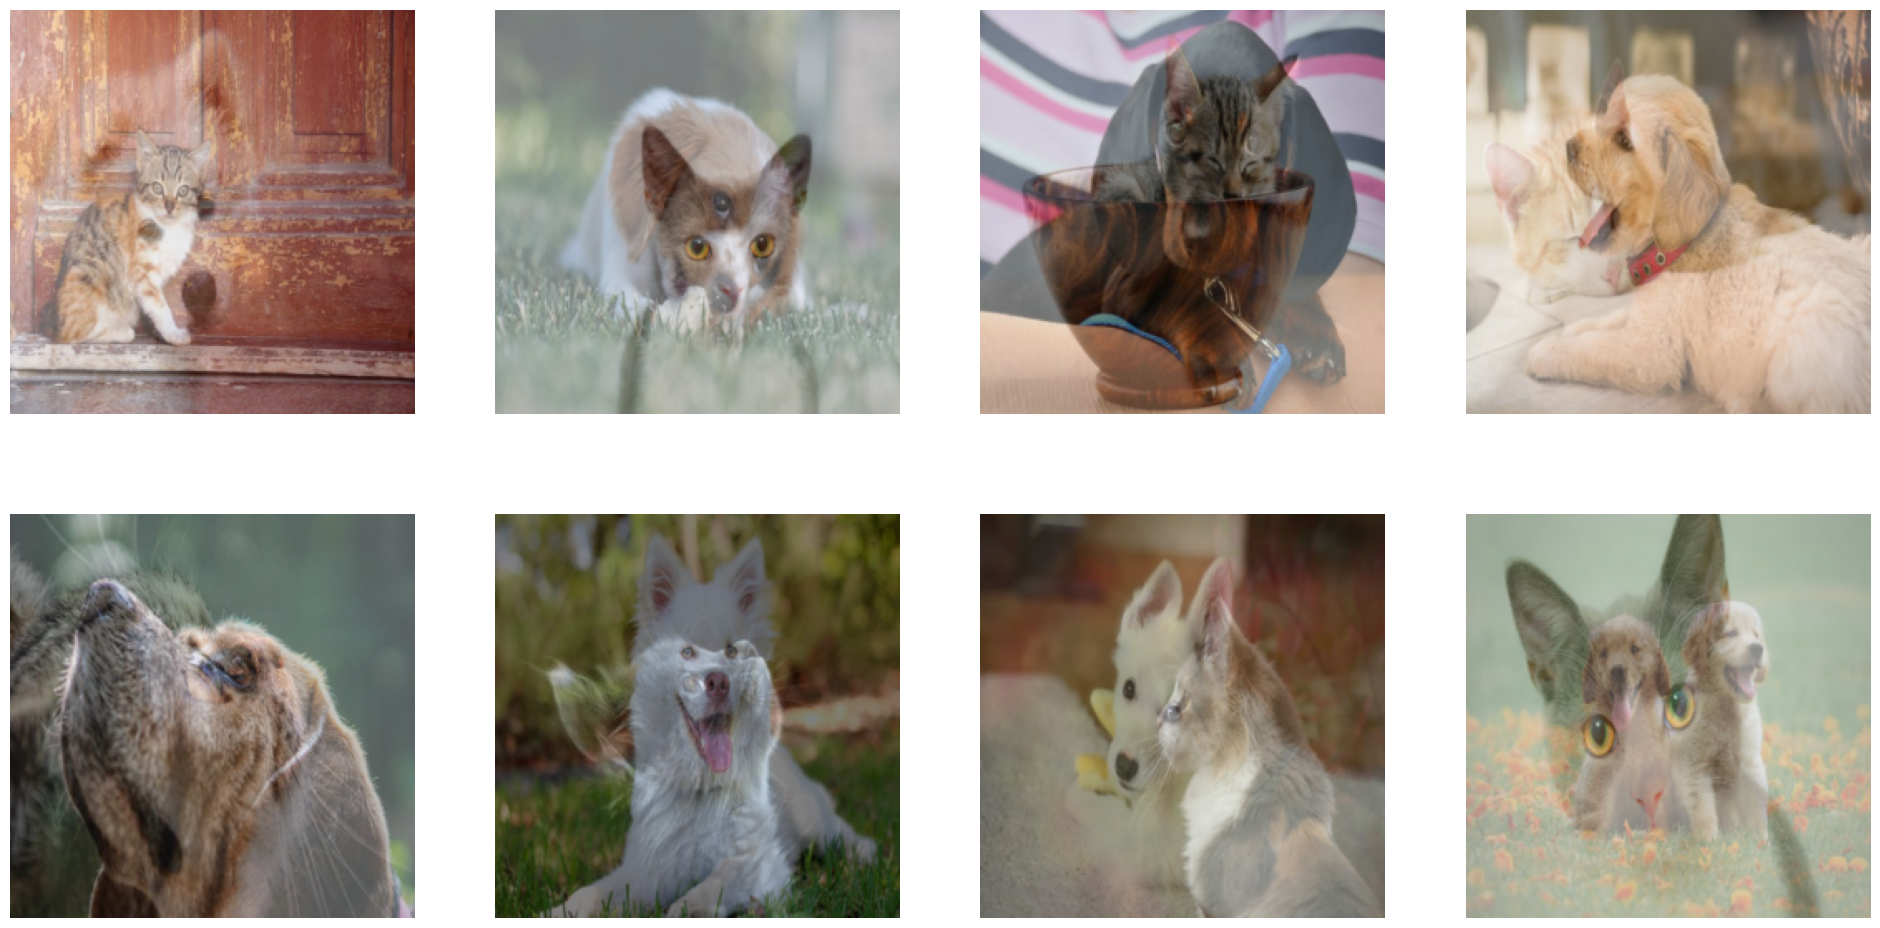

In [8]:
local_batches = [x.data for x in batch["images"].addressable_shards]
assert len(local_batches) == 1

show_image(local_batches[0])